# **Week2 복습과제**

**1. [ANN]**

**2. [CNN]**

- 데이터는 Week 1 과 같이 MNIST (0-9 숫자 분류) 데이터셋입니다.
- 이때, 우리의 복습과제에서는 0-4 숫자 분류를 위한 데이터 샘플만 사용할 예정입니다
- 아래 코드를 실행시켜 주세요

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
import random

# Tensor 변환을 위함
transform = transforms.Compose([
    transforms.ToTensor()
])

# MNIST 데이터셋 불러오기
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

# 무작위로 샘플 인덱스 선택
train_indices = [i for i, label in enumerate(train_dataset.targets) if label in [0, 1, 2, 3, 4]]
test_indices = [i for i, label in enumerate(test_dataset.targets) if label in [0, 1, 2, 3, 4]]

# Subset을 사용하여 샘플링된 데이터셋 생성
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)


# DataLoader 생성
batch_size = 64  # 배치 크기는 64로 설정 (batch_size를 다르게 실행해보셔도 좋습니다)
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.5MB/s]


In [2]:
# 데이터셋 크기 확인을 위해 해당 셀을 실행시켜 주세요
print(f"Train dataset size: {len(train_subset)}")
print(f"Test dataset size: {len(test_subset)}")

Train dataset size: 30596
Test dataset size: 5139


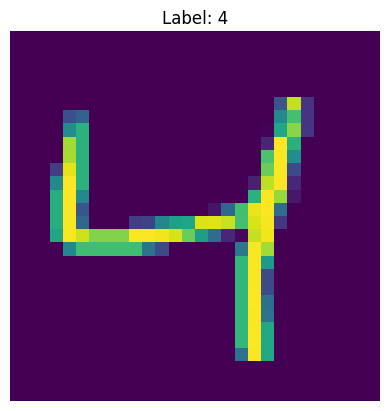

In [5]:
# 데이터셋 중 하나의 이미지를 시각화해보기
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋에서 하나의 샘플 가져오기
image, label = train_subset[1]

# 텐서를 NumPy 배열로 변환
image = image.numpy().squeeze()

# 이미지 출력
plt.imshow(image)  # 이미지 표시
plt.title(f"Label: {label}")  # 레이블 표시
plt.axis("off")  # 축 없애기
plt.show()

<a id="1"></a> <br>
## **1. ANN**

**인공 신경망 (ANN)**

>  로지스틱 회귀는 분류 문제에서 성능이 좋지만, 데이터의 비선형성이 증가하면 모델의 정확도가 감소합니다.

>  따라서, hidden lyaer 에 더 많은 비선형 함수를 추가시켜 모델의 복잡도를 증가시켜 봅시다. 😀

↪ **3개의 hidden layer를 쌓고 다양한 활성화 함수 ReLU, Tanh, ELU 사용해봅시다**


In [6]:
# 필요한 라이브러리 임포트
import torch
import torch.nn as nn

#### **ANN 모델 생성**

In [7]:
# ANN Model
class ANNModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()

        # Linear function 1: ____ --> ____  (입력 차원에서 숨겨진 계층으로)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Non-linearity 1 (ReLU 활성화 함수)
        self.relu1 = nn.ReLU()

        # Linear function 2: ____ --> ____  (숨겨진 계층을 한 번 더 통과)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2 (Tanh 활성화 함수 사용)
        self.tanh2 = nn.Tanh()

        # Linear function 3: ____ --> ____  (추가 숨겨진 계층)
        self.fc3 = nn.Linear(hidden_dim,hidden_dim)
        # Non-linearity 3 (ELU 활성화 함수)
        self.elu3 = nn.ELU()

        # Linear function 4: ____ --> ____  (마지막 출력층)
        self.fc4 = nn.Linear(hidden_dim,output_dim)

    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)

        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.tanh2(out)

        # Linear function 3
        out = self.fc3(out)
        # Non-linearity 3
        out = self.elu3(out)

        # Linear function 4
        out = self.fc4(out)  # 마지막 출력층
        return out

In [8]:
# ANN 객체 생성
input_dim =28*28  # 이미지 크기 (28x28)
hidden_dim = 150  # 하이퍼파라미터 (150으로 설정)
output_dim = 5  # 출력 클래스 개수 (0~4)


model = ANNModel(input_dim,hidden_dim,output_dim)
# 손실 함수 설정
loss_ftn = nn.CrossEntropyLoss() # 다중분류에 적합한 손실함수를 선택해주세요

# SGD Optimizer 사용 - 다른 옵티마이저를 사용해보셔도 됩니다 :)
learning_rate = 0.02
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### **ANN 모델 학습**

In [10]:
# ANN 모델 학습

# 학습을 모니터링하기 위한 변수들
count = 0  # 반복 횟수
loss_list = []  # Loss 저장 리스트
iteration_list = []  # Iteration 저장 리스트
accuracy_list = []  # 정확도 저장 리스트

# 전체 학습
for epoch in range(10):

    # 배치 단위 학습
    for i, (images, labels) in enumerate(train_loader):

        # 데이터를 모델 입력 형태로 변환 (2D 텐서로 펼치기)
        train = images.view(-1,28*28)  # 28x28 이미지를 펼쳐서 1D 벡터로 변환
        labels = labels  # 텐서 형태 유지

        # 옵티마이저의 기울기 초기화
        optimizer.zero_grad()

        # Forward
        # 모델을 이용해 예측값(outputs) 계산
        outputs = model(train)

        # 손실 계산
        # cross entropy loss를 사용해 예측값과 실제값 비교
        loss = loss_ftn(outputs, labels)

        # Backward propagation - 손실에 대한 기울기 계산
        loss.backward()

        # 가중치 업데이트
        optimizer.step()

        count += 1  # 반복 횟수 증가

        if count % 50 == 0:
            # 정확도 계산을 위한 변수 초기화
            correct = 0
            total = 0


            # 모델이 테스트 데이터셋에서 얼마나 잘 예측하는지 확인
            for images, labels in test_loader:

                test = images.view(-1, 28*28)  # 28x28 이미지를 펼쳐서 1D 벡터로 변환
                # Forward
                # 예측값 계산
                outputs = model(test)

                # 예측값 중 가장 높은 값을 선택
                predicted = torch.max(outputs.data, 1)[1]

                # 총 샘플 개수
                total += len(labels)

                # 올바르게 예측한 개수
                correct += (predicted == labels).sum()

            # 정확도 계산
            accuracy = 100 * correct / float(total)

            # 손실 및 정확도 저장
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if count % 500 == 0:
            # 손실 및 정확도 출력
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))


Iteration: 500  Loss: 0.2392287701368332  Accuracy: 97.7038345336914 %
Iteration: 1000  Loss: 0.06931799650192261  Accuracy: 97.45086669921875 %
Iteration: 1500  Loss: 0.046127285808324814  Accuracy: 96.14710998535156 %
Iteration: 2000  Loss: 0.28232914209365845  Accuracy: 88.88888549804688 %
Iteration: 2500  Loss: 0.15566450357437134  Accuracy: 93.4812240600586 %
Iteration: 3000  Loss: 0.1379925161600113  Accuracy: 96.8476333618164 %
Iteration: 3500  Loss: 0.3638838529586792  Accuracy: 96.90601348876953 %
Iteration: 4000  Loss: 0.07568039000034332  Accuracy: 96.96439361572266 %
Iteration: 4500  Loss: 0.04110123589634895  Accuracy: 96.92546844482422 %


#### **ANN 학습 결과**

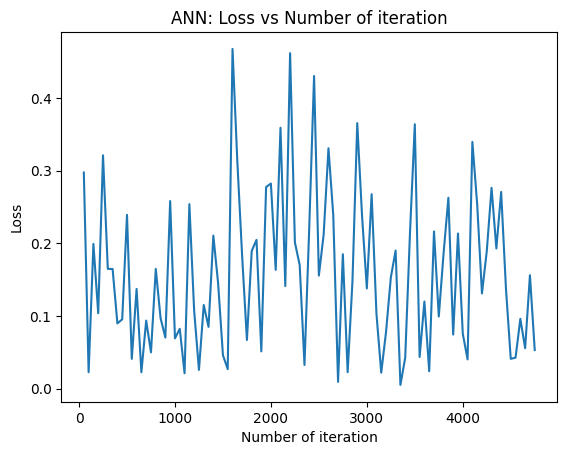

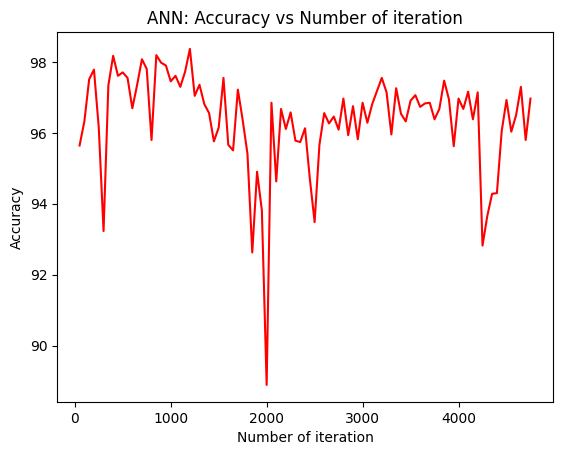

In [11]:
# loss 시각화
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# accuracy 시각화
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()

**해당 셀의 마크 다운을 풀고 시각화된 모델의 학습 결과를 해석해주세요.** 🤗



---
**[해석]**
- iteration이 반복될수록 loss가 점점 낮아지고 accuracy가 높아질 줄 알았는데 생각보다 그렇지 않았다.
- 전체적으로 Loss가 매끄럽게 줄지 않고 큰 변동성을 보임. 최종적으로 봤을 때는 accuracy와 loss둘다 각각 최고치/최저치에 가까워서 학습이 잘된것같다.


#### **ANN 최적의 하이퍼파라미터 찾기**

1️⃣ **실험 1: Hidden Dimension 최적값 찾기**
- hidden_dim 값을 50-200 사이 값들로 설정하고 모델을 학습
- 각 hidden_dim 값에 대해 학습을 수행하면서 loss과 accuracy를 저장
- 모든 결과를 한 그래프에 표시하여 비교




2️⃣ **실험 2: Learning Rate 최적값 찾기**

- learning_rate 값을 0.1-0.005 사이 값들로 설정하고 모델을 학습
- 각 learning_rate 값에 대해 학습을 수행하면서 loss과 accuracy를 저장
- 모든 결과를 한 그래프에 표시하여 비교



**⚠ 이때 epoch 값은 자유롭게 해주셔도 됩니다! **

In [ ]:
# 실험 1 hidden_dims=[50-200 사이 값들] 로 학습

In [13]:
import torch, random, numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

def accuracy_of(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            x = images.view(-1, 28*28).to(device)
            y = labels.to(device)
            logits = model(x)
            pred = logits.argmax(1)
            total += y.size(0)
            correct += (pred == y).sum().item()
    return 100.0 * correct / total

def train_model(hidden_dim, lr, epochs, train_loader, test_loader, input_dim=28*28, output_dim=5):
    set_seed(42)  # 각 설정마다 동일 seed → 공정 비교
    model = ANNModel(input_dim, hidden_dim, output_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    hist = {"epoch": [], "train_loss": [], "test_acc": []}

    for ep in range(1, epochs+1):
        model.train()
        running = 0.0
        for images, labels in train_loader:
            x = images.view(-1, 28*28).to(device)
            y = labels.to(device)

            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            running += loss.item() * y.size(0)

        avg_loss = running / len(train_loader.dataset)
        acc = accuracy_of(model, test_loader)

        hist["epoch"].append(ep)
        hist["train_loss"].append(avg_loss)
        hist["test_acc"].append(acc)

    return hist


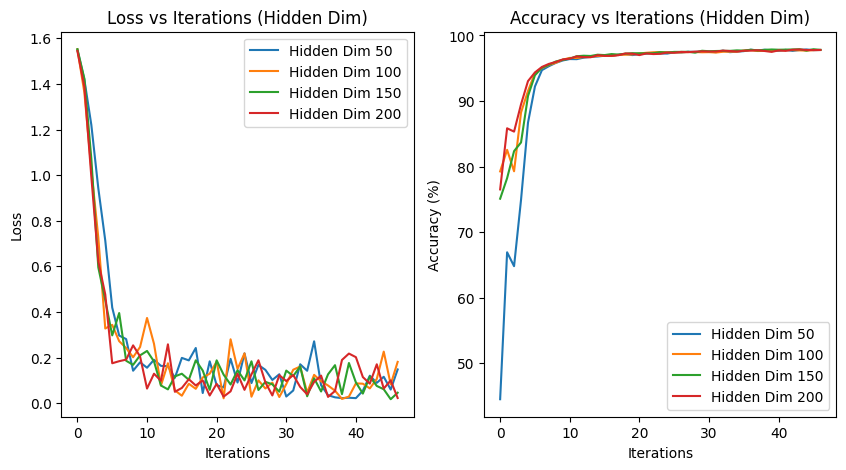

In [ ]:
# 실험 1 모델 학습 결과 시각화

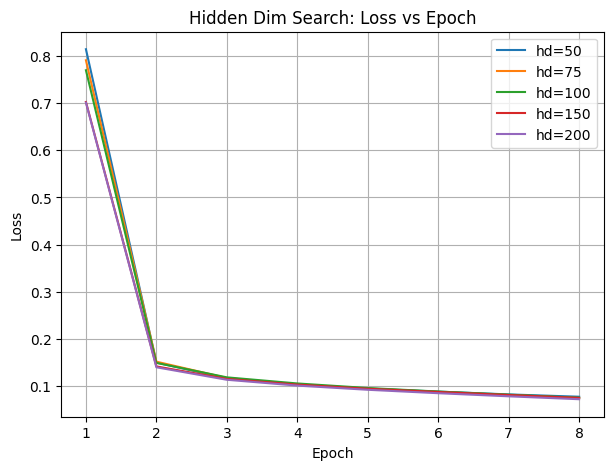

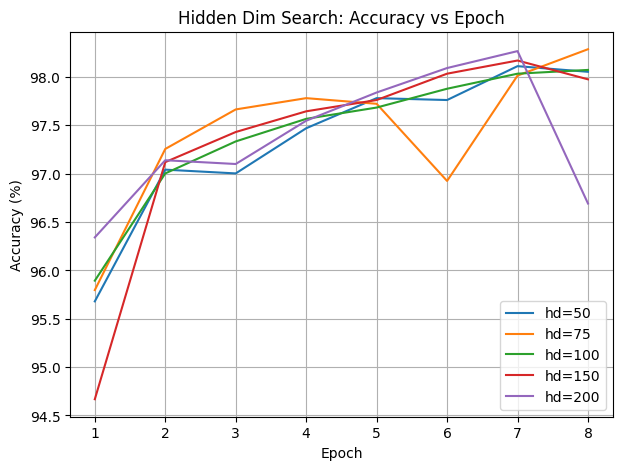

HiddenDim 최종 정확도 순위: [(75, 98.28760459233314), (100, 98.07355516637477), (50, 98.05409612765129), (150, 97.97625997275735), (200, 96.6919634170072)]


In [14]:
hidden_grid = [50, 75, 100, 150, 200]
epochs = 8  # 자유롭게 조정
lr = 0.02   # 고정 (공정 비교)

hd_histories = {}
for hd in hidden_grid:
    h = train_model(hidden_dim=hd, lr=lr, epochs=epochs,
                    train_loader=train_loader, test_loader=test_loader)
    hd_histories[hd] = h

# 그래프: Loss
plt.figure(figsize=(7,5))
for hd, h in hd_histories.items():
    plt.plot(h["epoch"], h["train_loss"], label=f"hd={hd}")
plt.title("Hidden Dim Search: Loss vs Epoch")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
plt.show()

# 그래프: Accuracy
plt.figure(figsize=(7,5))
for hd, h in hd_histories.items():
    plt.plot(h["epoch"], h["test_acc"], label=f"hd={hd}")
plt.title("Hidden Dim Search: Accuracy vs Epoch")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.legend(); plt.grid(True)
plt.show()

# 최종 에폭 결과로 Top-1 출력
final_acc_hd = sorted([(hd, h["test_acc"][-1]) for hd, h in hd_histories.items()],
                      key=lambda x: x[1], reverse=True)
print("HiddenDim 최종 정확도 순위:", final_acc_hd)


**해당 셀의 마크 다운을 풀고 hidden dimension 값이 모델의 학습에 주는 영향을 설명해주세요.** 🤗



---
**[답변]**
- 이 데이터셋에서는 Loss에 한에서는 hidden dimension값이 큰 영향을 주지는 않은 것 같다. epoch 8쯤에는 거의 비슷한 값으로 보인다.
- accuracy는 의외로 제일 높은 값인 200일 때 제일 낮았다.
- hidden dimension값이 100일 때가 제일 안정적으로 정확도가 올라간 것으로보아 제일 안정적으로 학습된 것 같다.

In [15]:
# 실험 2 learning_rates=[0.1-0.005 사이 값들] 로 학습
lr_grid = [0.1, 0.05, 0.02, 0.01, 0.005]
epochs = 8             # 자유롭게 조정
hidden_dim = 150       # 고정 (공정 비교)

lr_histories = {}
for lr in lr_grid:
    h = train_model(hidden_dim=hidden_dim, lr=lr, epochs=epochs,
                    train_loader=train_loader, test_loader=test_loader)
    lr_histories[lr] = h


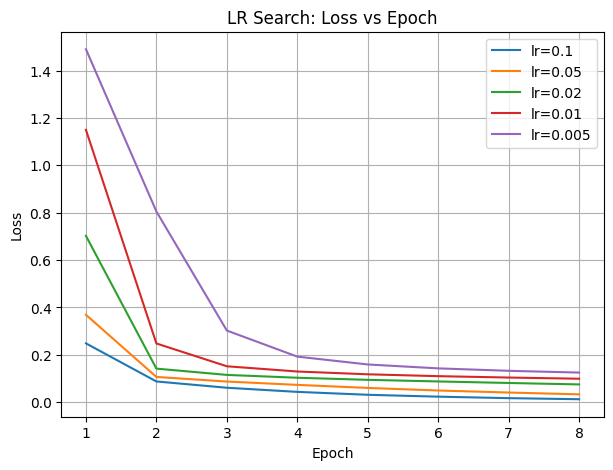

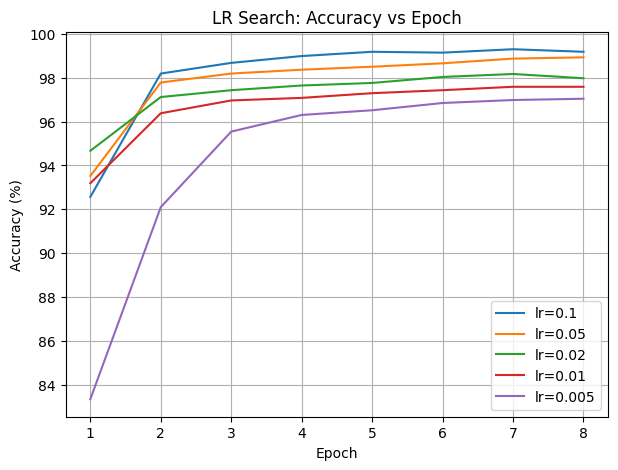

In [16]:
# 실험 2 모델 학습 결과 시각화

# 그래프: Loss
plt.figure(figsize=(7,5))
for lr, h in lr_histories.items():
    plt.plot(h["epoch"], h["train_loss"], label=f"lr={lr}")
plt.title("LR Search: Loss vs Epoch")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
plt.show()

# 그래프: Accuracy
plt.figure(figsize=(7,5))
for lr, h in lr_histories.items():
    plt.plot(h["epoch"], h["test_acc"], label=f"lr={lr}")
plt.title("LR Search: Accuracy vs Epoch")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.legend(); plt.grid(True)
plt.show()


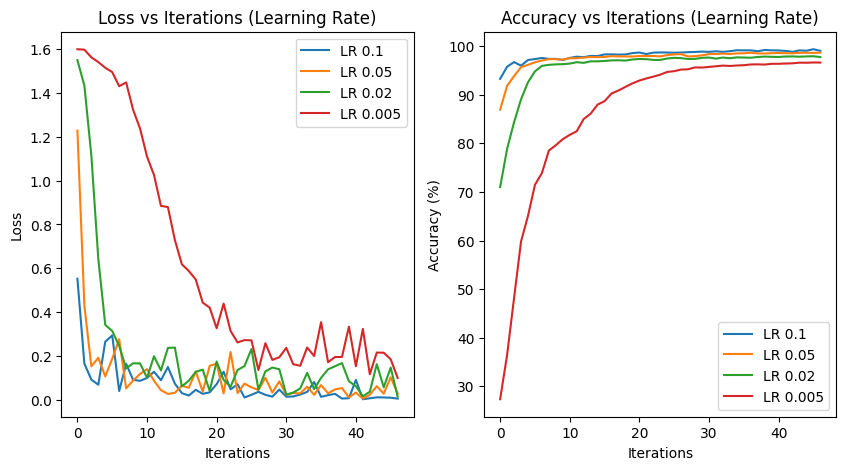

In [ ]:
# 실험 2 모델 학습 결과 시각화
## 답안 ##

**해당 셀의 마크 다운을 풀고 learning rate 값이 모델의 학습에 주는 영향을 설명해주세요.** 🤗



---
**[답변]**
-
-

<a id="1"></a> <br>
## **2. CNN**
> CNN은 이미지 분류에 적합한 모델로, kernel을 이용해 feature map을 생성합니다

**↪ 2개의 합성곱 계층을 쌓고, 활성화 함수로 ReLU를 사용하며,Max Pooling layer를 적용해봅시다.**

#### **CNN 모델 생성**

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

# CNN Model 정의
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # 합성곱 계층 1 (Conv Layer 1)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()  # 활성화 함수 (ReLU)

        # Max Pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2) # kernel size를 2로 설정

        # 합성곱 계층 2 (Conv Layer 2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()  # 활성화 함수 (ReLU)

        # Max Pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=2) # kernel size를 2로 설정

        # Fully Connected Layer
        self.fc1 = nn.Linear(32 * 4 * 4, 5)  # 입력 차원 및 출력 차원 지정

    def forward(self, x):
        # 합성곱 계층 1 + 활성화 함수
        out = self.cnn1(x)
        out = self.relu1(out)

        # Max Pooling 1
        out = self.maxpool1(out)

        # 합성곱 계층 2 + 활성화 함수
        out = self.cnn2(out)
        out = self.relu2(out)

        # Max Pooling 2
        out = self.maxpool2(out)

        # feature map을 flatten하게
        out = out.view(out.size(0),-1)

        # 완전 연결 계층
        out = self.fc1(out)

        return out


In [18]:
# CNN 객체 생성
model = CNNModel()
# 손실 함수 설정
loss_ftn = nn.CrossEntropyLoss()  # 다중분류에 적합한 손실함수를 선택해주세요

# SGD Optimizer 사용 - 다른 옵티마이저를 사용해보셔도 됩니다 :)
optimizer = optim.SGD(model.parameters(), lr=0.01)  # 학습률을 자유롭게 설정해주세요

#### **CNN 모델 학습**

In [20]:
# CNN 모델 학습

# 학습을 모니터링하기 위한 변수들
count = 0  # 반복 횟수
loss_list = []  # Loss 저장 리스트
iteration_list = []  # Iteration 저장 리스트
accuracy_list = []  # 정확도 저장 리스트
num_epochs = 20  # 학습할 에포크 수 설정 -> 자유롭게 설정해주셔도 됩니다

for epoch in range(num_epochs):
    running_loss = 0.0  # 에포크별 손실 초기화
    model.train()
    for images, labels in train_loader:
        # 옵티마이저의 기울기 초기화
        optimizer.zero_grad()

        # Forward
        outputs = model(images)

        # 손실 계산
        loss = loss_ftn(outputs,labels)

        # Backward
        loss.backward()

        # 가중치 업데이트
        optimizer.step()

        # 손실 누적
        running_loss += loss.item()
        count += 1  # 반복 횟수 증가

        if count % 50 == 0:
            correct = 0
            total = 0

            model.eval()
            with torch.no_grad():  # 평가
                for images, labels in test_loader:
                    # 모델 예측 수행
                    outputs = model(images)

                    # 가장 확률이 높은 클래스 선택
                    predicted = torch.max(outputs.data,1)[1]

                    # 총 샘플 수 및 올바른 예측 개수 누적
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            # 정확도 계산
            accuracy = 100 * correct / float(total)

            # 손실 및 정확도 저장
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)

    # 매 에포크마다 평균 손실 출력
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

Epoch 1, Loss: 0.5017872058430644
Epoch 2, Loss: 0.1245604018157733
Epoch 3, Loss: 0.10175128801704418
Epoch 4, Loss: 0.08705308671752944
Epoch 5, Loss: 0.0754677933258722
Epoch 6, Loss: 0.06576597953889915
Epoch 7, Loss: 0.05989201416794113
Epoch 8, Loss: 0.053829265373422606
Epoch 9, Loss: 0.04970564684365917
Epoch 10, Loss: 0.04567342700005562
Epoch 11, Loss: 0.04266874461241809
Epoch 12, Loss: 0.039858823187227825
Epoch 13, Loss: 0.03777550325081499
Epoch 14, Loss: 0.035422176525136746
Epoch 15, Loss: 0.03411100425520262
Epoch 16, Loss: 0.03263445499198538
Epoch 17, Loss: 0.031139840096301382
Epoch 18, Loss: 0.029661168110273032
Epoch 19, Loss: 0.02864956005042835
Epoch 20, Loss: 0.027220232997151355


#### **CNN 학습 결과**

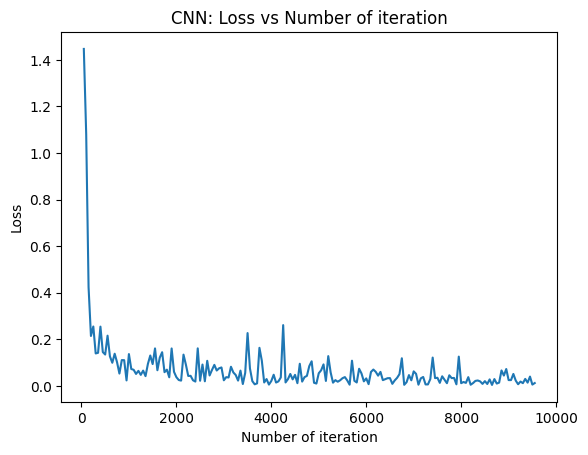

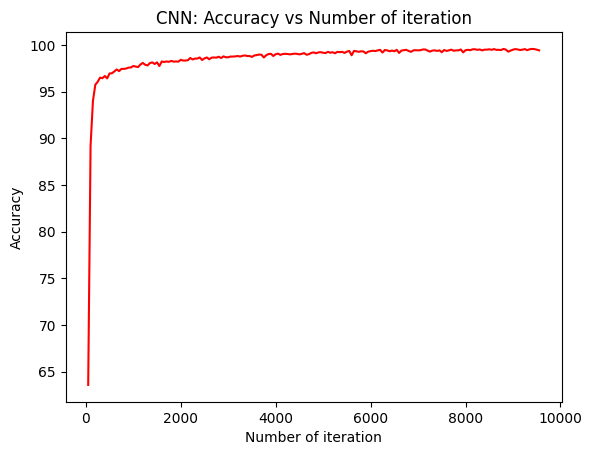

In [21]:
# loss 시각화
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# accuracy 시각화
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

**해당 셀의 마크 다운을 풀고 MNIST 데이터셋에서 ANN, CNN의 학습 결과 비교와 함께 두 모델에 대해 각각 짧게 소개해주세요.** 🤗



---
**[답변]**
- CNN이 좀더 loss가 안정적으로 감소하고 Accuracy도 안정적으로 증가한거같다. iteration의 수가 많은 것을 고려해도 좀 더 안정적인 학습이 된 것 같다.

- ANN ( Artificial Neural Network, 인공신경망 )
  - 입력층-> 은닉층-> 출력, 모든 입력이 모든 뉴런에 입력됨.

- CNN ( Convolutional Neural Network, 합성곱 신경망 )
  - 합성곱 계층 + 풀링, 계층이 깊어질수록 더 추상적인 특징 학습
  - 이미지를 1d로 flatten하지 않고 2d그대로 처리 가능
  - 이미지 분류에 더 강력한 성능